<a href="https://colab.research.google.com/github/jfzhang726/da_2021Dec/blob/main/notebooks/Airbnb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis Airbnb #



### Overview ###
<b><I>insideairbnb.com</I></b> scrapes data from AirBnb website regularly, organizes the data into individual cities, and publish these datasets approximately one dataset per city per month. 

http://insideairbnb.com/get-the-data.html

![](https://drive.google.com/uc?export=view&id=1pTg7TcxpLWLUxh-GYLcfWHgz8QIZTfDW)


<br><br>
This analysis uses data of <I>Sydney November 2021</I> as the main data source. We use two files (highlighted in green) in this notebook to look into two topics:
1. Host

  We start by looking at fundemental statistic characteristics of hosts, then put emphesis on <b>Business Sizes of AirBnb Hosts</b>.
2. Properties

  Similarily, we look at fundemental statistic characteristics of properties, then put emphesis on  <b>Grouping Properties Based on Guest Reviews</b>. 


![](https://drive.google.com/uc?export=view&id=1MgpwjQjMVh_cHdTO9UuxTlOHjLVwfYwy)

We use data of several other cities from <b><i>insideairbnb.com</i></b> as supplementary material to support our analysis.


## Prepare analysis tools ##
- install analysis packages
- make files in my Google Drive folder available to this notebook
- import Python packages
- create helper functions


In [1]:
# Install Python packages. 
!apt install libgraphviz-dev
!pip install pygraphviz
!pip install pydot
!pip install powerlaw

# Important library for many geopython libraries
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  cuda-command-line-tools-10-0 cuda-command-line-tools-10-1
  cuda-command-line-tools-11-0 cuda-compiler-10-0 cuda-compiler-10-1
  cuda-compiler-11-0 cuda-cuobjdump-10-0 cuda-cuobjdump-10-1
  cuda-cuobjdump-11-0 cuda-cupti-10-0 cuda-cupti-10-1 cuda-cupti-11-0
  cuda-cupti-dev-11-0 cuda-documentation-10-0 cuda-documentation-10-1
  cuda-documentation-11-0 cuda-documentation-11-1 cuda-gdb-10-0 cuda-gdb-10-1
  cuda-gdb-11-0 cuda-gpu-library-advisor-10-0 cuda-gpu-library-advisor-10-1
  cuda-libraries-10-0 cuda-libraries-10-1 cuda-libraries-11-0
  cuda-memcheck-10-0 cuda-memcheck-10-1 cuda-memcheck-11-0 cuda-nsight-10-0
  cuda-nsight-10-1 cuda-nsight-11-0 cuda-nsight-11-1 cuda-nsight-compute-10-0
  cuda-nsight-compute-10-1 cuda-nsight-compute-11-0 cuda-nsight-compute-11-1
  cuda-nsight-systems-10-1 cuda-nsight-systems-

In [2]:
# Make files in my Google Drive folder available to this notebook.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
ON_COLAB = True
if ON_COLAB:
  DIR_PREFIX = '/content/drive/MyDrive/data/'
else:
  DIR_PREFIX = './'

In [4]:
# Import libraries.

import plotly.offline as pyo
# Set notebook mode to work in offline
pyo.init_notebook_mode()
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from PIL import Image

#import seaborn as sns
import geopandas as gpd
import pprint

import numpy as np

from bs4 import BeautifulSoup
import nltk

import spacy
from collections import Counter

from wordcloud import WordCloud
import math
#plt.rcParams['figure.figsize'] = [20, 15]

from sklearn.linear_model import LinearRegression

import powerlaw
np.seterr(divide='ignore', invalid='ignore')

import warnings
warnings.filterwarnings('ignore')
from IPython.display import HTML, Markdown

In [5]:
# Helper functions.

nlp = spacy.load('en_core_web_sm')
def lemmatize(text):
  #if text is None or np.isnan(text):
  if text != text or not text:
    return []
  if type(text) == float:
    print(text)
  text = str(text)  
  return ' '.join([token.lemma_.lower() for token in nlp(text) if (token.is_alpha and not token.is_stop)])

def stripe_html_lemmatize(html_string):
  if html_string != html_string or html_string is None:
    return []
  text = BeautifulSoup(html_string, 'html.parser').get_text()
  return lemmatize(text)

def lemmaitize_text_in_listings(df_listings_detailed):
  df_listings_detailed['name_lemmas'] = df_listings_detailed['name'].apply(lemmatize)
  df_listings_detailed['host_about_lemmas'] = df_listings_detailed['host_about'].apply(lemmatize)
    
  df_listings_detailed['description_lemmas'] = df_listings_detailed['description'].apply(lambda html_string: stripe_html_lemmatize(html_string))
  df_listings_detailed['neighborhood_overview_lemmas'] = df_listings_detailed['neighborhood_overview'].apply(lambda html_string: stripe_html_lemmatize(html_string))

def lemmatize_text_in_reviews(df_reviews_detailed):
  df_reviews_detailed['comments_lemmas'] = df_reviews_detailed['comments'].apply(lambda html_string: stripe_html_lemmatize(html_string))





## Analytics of Hosts ##

This analysis uses listing data.

<b>Load data </b>





In [6]:
df_listings_detailed = pd.read_csv(DIR_PREFIX + "data_airbnb_syd/20211106/listings_detailed.csv", 
                                       header='infer', 
                                       parse_dates=['last_scraped', 'host_since', 'calendar_last_scraped'])
df_listings_detailed.head(2)

id  ... reviews_per_month
0  11156  ...              2.02
1  14250  ...              0.04

[2 rows x 74 columns]

<b>Question: How many hosts, properties, etc are covered by the data? </b>

<b>Answer:</b> 

Summary of Data:



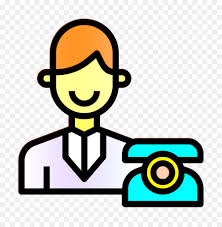
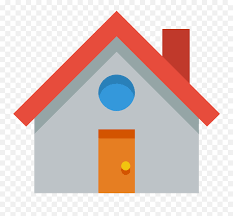
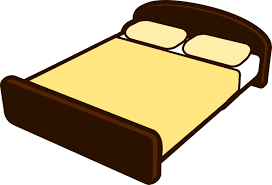
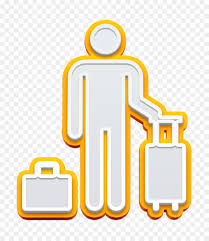

In [7]:
min_scrape_date = df_listings_detailed['last_scraped'].min().strftime('%Y-%m-%d')
max_scrape_date = df_listings_detailed['last_scraped'].max().strftime('%Y-%m-%d')

listings_data_info = np.array([
                               ['Scrape Date', min_scrape_date + ' to ' + max_scrape_date], 
                               ['City', 'Sydney'],
                               ['Suburb Number', df_listings_detailed['neighbourhood_cleansed'].nunique()],
                               ['Host Number', df_listings_detailed['host_id'].nunique()],
                               ['Property Number', df_listings_detailed['id'].nunique()], 
                               ['Bedroom Number', df_listings_detailed['bedrooms'].sum().astype(int)],
                               ['Accommodate Number', df_listings_detailed['accommodates'].sum()],
                               ['Earlist Host', df_listings_detailed['host_since'].min().strftime('%Y-%m-%d')],
                               ['Most Recent Host', df_listings_detailed['host_since'].max().strftime('%Y-%m-%d')]
                               ])
listings_data_info = pd.DataFrame(listings_data_info, columns=['name', 'value'])

print('Summary of Data:')
display(HTML(listings_data_info.to_html(index=False, header=False)))

df_to_plot = listings_data_info[listings_data_info['name'].isin(['Host Number', 'Property Number', 'Bedroom Number', 'Accommodate Number'])]
df_to_plot = df_to_plot.astype({'value': 'int32'})
fig = go.Figure()
fig.add_trace(go.Bar(
                 x=df_to_plot['name'],
                 y=df_to_plot['value'],
                 )
             )
icon_names = {}
icon_names['Host Number'] = DIR_PREFIX+"images/icon_host.jpg"
icon_names['Property Number'] = DIR_PREFIX+"images/icon_house.png"
icon_names['Bedroom Number'] = DIR_PREFIX+"images/icon_bed.png"
icon_names['Accommodate Number'] = DIR_PREFIX+"images/icon_guest.jpg"

for x in fig.data[0].x:
  fig.add_layout_image(
      source=Image.open(icon_names[x]),
      x=x,
      y=-0.1,
      xref='x',
      yref='paper',
      xanchor='center',
      sizex=0.3,
      sizey=0.3
  )
fig.update_layout(
    #xaxis={"visible":False}
    title='Fig 1. Coverage of Data',
    width=800,
    height=600,
    #yaxis_range=[-10000, 80000]
    )
fig.show(renderer="colab")

<b>Question: How long have these hosts been in business? </b>

<b>Answer: </b> 


In [8]:
df_listings_detailed['host_years_to_now'] = round((pd.datetime.today() - df_listings_detailed['host_since']).dt.days / 365)

host_years_info = np.array([['Longest', df_listings_detailed['host_years_to_now'].max()],
                            ['Shortest', df_listings_detailed['host_years_to_now'].min()],
                            ['Average', round(df_listings_detailed['host_years_to_now'].mean(), 2)],
                            ['Median', round(df_listings_detailed['host_years_to_now'].median(),2)]])

display(HTML("<b>Host's Years in Business</b>"))
host_years_info = pd.DataFrame(host_years_info, columns=['name', 'Years'])
display(HTML(host_years_info.to_html(index=False, header=False)))

mean_years = df_listings_detailed['host_years_to_now'].mean()
median_years = df_listings_detailed['host_years_to_now'].median()

fig = px.histogram(df_listings_detailed, 
                   x='host_years_to_now',
                   labels={'host_years_to_now': 'Years in Business (red line: average {:.1f} years, yellow line: median {:.1f} years)'.format(mean_years, median_years), 
                           'count': 'Number of Hosts'}, 
                   text_auto=True,
                   #name='Number of Hosts',
                   title="Fig 2. Hosts' Years in Business (x-axis: years, y-axis: host number)")

fig.add_shape(type='line',
                x0=mean_years,
                y0=0,
                x1=mean_years,
                y1=4000,
                line=dict(color='Red',),
                xref='x',
                yref='y'
)
fig.add_shape(type='line',
                x0=median_years,
                y0=0,
                x1=median_years,
                y1=4000,
                line=dict(color='yellow',),
                xref='x',
                yref='y'
)
fig.show(renderer='colab')

display(HTML(
    '''
    <font size='4'>
    Diagram above (Fig 2) shows a <i>bell shape</i>:<br>
<li> Average: 6 years (so is in Median) </li>
<li> Earliest hosts: 13 years </li>
<li> Latest hosts: < 1 year </li>
<li> Grouping hosts by years in business </li>
  <ul>
  <li> 6 years group is the biggest </li>
  <li> Group of every 1 year longer or shorter is smaller </li> 
  </ul>

<i>Clarification:
Result above is applied to hosts who were in business at the scrape date, which does not include hosts who stopped business previously. So we cannot interpret e.g. average value 6 in above result as the average business lifespan of AirBnb hosts.<i>  
    </font>
    '''
))

<b>Question: Hosts operate how many properties (sizes of hosts)?  </b>

<b>Answer: </b> 
<!---
<b>Fig 3</b> shows a very skewed distribution of number of hosts operating 1, 2, 3, ... properties:
- biggest number (> half) of hosts have least properties (1 per host)
- lines of median and average properties are very small (on far left side)
- the distribution tails slowly downward to the right (long tail)

<b>Fig 4</b> redraws the same data in logrithm-logrithm plot. It becomes more clear that a <b><i>straight line</i></b> is present, which often (not always) indicates Power Law. 

-->

In [9]:
df_host_property_number = df_listings_detailed.groupby('host_id')['id'].nunique()
df_host_property_number = df_host_property_number.reset_index()
df_host_property_number.columns = ["host_id", "listing_number"]

host_listings_count_info = np.array([['Minimal', df_host_property_number['listing_number'].min()],
                                     ['Maximal', df_host_property_number['listing_number'].max()],
                                     ['Average', round(df_host_property_number['listing_number'].mean(),2)],
                                     ['Median', round(df_host_property_number['listing_number'].median(),2)]])

host_listings_count_info = pd.DataFrame(host_listings_count_info)
display(Markdown(
'''
<b>Basic statistics of host sizes (number of properties):</b>
'''
))
display(HTML(host_listings_count_info.to_html(index=False, header=False)))

df_host_property_number_group = df_listings_detailed.groupby('host_id')['id'].nunique().value_counts()
df_host_property_number_group = df_host_property_number_group.reset_index()
df_host_property_number_group.columns = ["host_listing_number", "host_number"]
df_host_property_number_group.sort_values(by=['host_listing_number'], axis=0, ascending=True, inplace=True, ignore_index=True)

mean_number = df_host_property_number['listing_number'].mean()
median_number = df_host_property_number['listing_number'].median()

display(Markdown(
'''
<br>
<font size='4'>
Diagram below (Fig 3) shows a very skewed distribution of number of hosts operating 1, 2, 3, ... properties:
<li> biggest number (> half) of hosts have smallest size (1 property per host) </li>
<li> lines of median and average sizes are very small (on far left side) </li>
<li> the distribution tails slowly downward to the right (long tail) </li>
</font>
<br>
'''
))
fig = px.bar(df_host_property_number_group,
             x='host_listing_number',
             y='host_number',
             labels={'host_listing_number': "Host Size (red line: average {:.1f} properties, yellow line: median {:.1f} properties)".format(mean_number, median_number),
                     'host_number': 'Number of Hosts (logrithm)' 
                    },
             log_y=True,
             title="Fig 3. NSW AirBnb Host Sizes (x-axis: host size, y-axis: logrithm of host number)"
            )

fig.add_shape(type='line',
                x0=mean_number,
                y0=0,
                x1=mean_number,
                y1=1,
                line=dict(color='Red',),
                xref='x',
                yref='paper'
)
fig.add_shape(type='line',
                x0=median_number,
                y0=0,
                x1=median_number,
                y1=1,
                line=dict(color='yellow',),
                xref='x',
                yref='paper'
)
#fig.update_layout(width=1200)

fig.show(renderer="colab")




<b>Basic statistics of host sizes (number of properties):</b>



<br>
<font size='4'>
Diagram below (Fig 3) shows a very skewed distribution of number of hosts operating 1, 2, 3, ... properties:
<li> biggest number (> half) of hosts have smallest size (1 property per host) </li>
<li> lines of median and average sizes are very small (on far left side) </li>
<li> the distribution tails slowly downward to the right (long tail) </li>
</font>
<br>


In [10]:
display(Markdown(
'''
<br>
<font size='4'>
Diagram below (Fig 4) redraws the same data in logrithm-logrithm plot. 
<br>It becomes more clear that a <b><i>straight line</i></b> is present, which often (not always) indicates Power Law. 
</font>
<br>
'''
))

fig = px.line(df_host_property_number_group,
             x='host_listing_number',
             y='host_number',
             labels={'host_listing_number': "Logrithm of Sizes (red line: average {:.1f} properties, yellow line: median {:.1f} properties)".format(mean_number, median_number),
                     'host_number': 'Logrithm of Number of Hosts' 
                    },
             log_y=True,
             log_x=True,
             title="Fig 4. NSW AirBnb Host Sizes Log-Log Plot (x-axis: logrithm of host size, y-axis: logrithm of host number)",
             
            )

fig.add_shape(type='line',
                x0=mean_number,
                y0=0,
                x1=mean_number,
                y1=1,
                line=dict(color='Red',),
                xref='x',
                yref='paper'
)
fig.add_shape(type='line',
                x0=median_number,
                y0=0,
                x1=median_number,
                y1=1,
                line=dict(color='yellow',),
                xref='x',
                yref='paper'
)

fig.show(renderer="colab")



<br>
<font size='4'>
Diagram below (Fig 4) redraws the same data in logrithm-logrithm plot. 
<br>It becomes more clear that a <b><i>straight line</i></b> is present, which often (not always) indicates Power Law. 
</font>
<br>


Power Law often indicates "rich get richer", "big get bigger" etc. 

If host sizes follow Power Law, the market would probably have a few dominating hosts eventually.

<b>Question: Does host sizes follow Power Law? </b>

<b>Answer:</b>

We use mathmetical tool to determine whether hosts' property number follows Power Law or not.

The tool we use is a library called <i>Powerlaw</i> (https://github.com/jeffalstott/powerlaw).




In [88]:
def test_powerlaw(listings_detailed, city, data_title=None, scrape_date=None, plot_data=False):
    if type(listings_detailed) == pd.DataFrame:
        df_listings_detailed = listings_detailed
    else:
        df_listings_detailed = pd.read_csv(listings_detailed, header='infer')
    
    total_host = df_listings_detailed['host_id'].unique().shape[0]
    total_listing = df_listings_detailed['id'].unique().shape[0]
        
    df_host_property_number = df_listings_detailed.groupby('host_id')['id'].nunique()
    df_host_property_number = df_host_property_number.reset_index()
    df_host_property_number.columns = ["host_id", "listing_number"]
    
    
    df_host_property_number_group = df_listings_detailed.groupby('host_id')['id'].nunique().value_counts()
    df_host_property_number_group = df_host_property_number_group.reset_index()

    df_host_property_number_group.columns = ["host_listing_number", "host_number"]
    df_host_property_number_group.sort_values(by=['host_listing_number'], axis=0, ascending=True, inplace=True, ignore_index=True)
    
    if plot_data:
        fig = px.line(df_host_property_number_group,
                      x='host_listing_number',
                      y='host_number',
                      labels={'host_listing_number': 'Number of Properties Listed by Same Host (log)',
                         'host_number': 'Number of Hosts (log)' 
                        },
                     log_y=True,
                     log_x=True,
                     title=data_title,
                     markers=True)
        fig.show()

    df_tmp = df_host_property_number_group.set_index('host_listing_number')
    add_indices = pd.Index(range(1, df_tmp.index.max()+1)).difference(df_tmp.index)
    add_df = pd.DataFrame(index=add_indices, columns=df_tmp.columns).fillna(0)
    df_continuous = pd.concat([df_tmp, add_df])
    df_continuous.sort_index(inplace=True)

    fit = powerlaw.Fit(df_continuous['host_number'].to_numpy(), discrete=False, estimate_discrete=False)
    
    rslt = {'city': city,
            'scrape_date': scrape_date,
            'dataset_name': data_title,
            'total_host': total_host,
            'total_listing': total_listing,
            'alpha': fit.power_law.alpha,
            'sigma': fit.power_law.sigma,
            'xmin': fit.power_law.xmin,
            'valid_sample_number': df_host_property_number_group[df_host_property_number_group['host_listing_number'] >= fit.power_law.xmin]['host_number'].count()
           }
    
    powerlaw_win = True
    R, p = fit.distribution_compare('power_law', 'exponential')
    powerlaw_win &= (R > 0)
    rslt['power_law_vs_exponential_R'] = R
    rslt['power_law_vs_exponential_p'] = p

    R, p = fit.distribution_compare('power_law', 'lognormal_positive')
    powerlaw_win &= (R > 0)
    rslt['power_law_vs_lognormal_positive_R'] = R
    rslt['power_law_vs_lognormal_positive_p'] = p
    rslt['prefer_power_law'] = powerlaw_win
        
    return rslt

rslt = test_powerlaw(listings_detailed=df_listings_detailed, data_title="Sydney AirBnb Hosts' Listing Numbers (Nov 2021)", city='Sydney', scrape_date='20211106', plot_data=False)
is_powerlaw = rslt['prefer_power_law']


display(HTML("<br><font size='4'>Result of testing Power Law: </font><br>" + 
    pd.DataFrame(np.array([['City', 'Data Scrape Date', 'Follow Power Law'],
                           ['Sydney', '06-11-2021', is_powerlaw],
                           
                            ])).to_html(index=False, header=False)    
))

Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


<b>Question: Is Power Law of host sizes unique to Sydney or common among cities? </b>

<b>Answer:</b>

We test Power Law in additional randomly selected 10 cities:
- Amsterdam
- Antwerp
- Athens
- Austin
- Bangkok
- Chicago
- Melbourne
- New_York
- Shanghai
- Tokyo

Result shows Power Law is demonstrated in <b>10 out of the 11 cities<b>. 

In [89]:


test_powerlaw_result = []
# Sydney
#rslt = test_powerlaw(listings_detailed=DIR_PREFIX+'data_airbnb_syd/20220108/listings.csv', data_title="Sydney AirBnb Hosts' Listing Numbers (Jan 2022)", city='Sydney', scrape_date='20220108')
#test_powerlaw_result.append(rslt)

#rslt = test_powerlaw(listings_detailed=DIR_PREFIX+'data_airbnb_syd/20211207/listings.csv', data_title="Sydney AirBnb Hosts' Listing Numbers (Dec 2021)", city='Sydney', scrape_date='20211207')
#test_powerlaw_result.append(rslt)

rslt = test_powerlaw(listings_detailed=DIR_PREFIX+'data_airbnb_syd/20211106/listings.csv', data_title="Sydney AirBnb Hosts' Listing Numbers (Nov 2021)", city='Sydney', scrape_date='20211106')    
test_powerlaw_result.append(rslt)

#rslt = test_powerlaw(listings_detailed=DIR_PREFIX+'data_airbnb_syd/20211009/listings.csv', data_title="Sydney AirBnb Hosts' Listing Numbers (Oct 2021)", city='Sydney', scrape_date='20211009')   
#test_powerlaw_result.append(rslt)

#rslt = test_powerlaw(listings_detailed=DIR_PREFIX+'data_airbnb_syd/20210908/listings.csv', data_title="Sydney AirBnb Hosts' Listing Numbers (Sept 2021)", city='Sydney', scrape_date='20210908')
#test_powerlaw_result.append(rslt)

#rslt = test_powerlaw(listings_detailed=DIR_PREFIX+'data_airbnb_syd/20210807/listings.csv', data_title="Sydney AirBnb Hosts' Listing Numbers (Aug 2021)", city='Sydney', scrape_date='20210807')
#test_powerlaw_result.append(rslt)

#rslt = test_powerlaw(listings_detailed=DIR_PREFIX+'data_airbnb_syd/20210705/listings.csv', data_title="Sydney AirBnb Hosts' Listing Numbers (Jul 2021)", city='Sydney', scrape_date='20210705')
#test_powerlaw_result.append(rslt)

# Melbourne
#rslt = test_powerlaw(listings_detailed=DIR_PREFIX+'data_airbnb_mel/20220108/listings.csv', data_title="Melbourne AirBnb Hosts' Listing Numbers (Jan 2022)", city='Melbourne', scrape_date='20220108')
#test_powerlaw_result.append(rslt)

#rslt = test_powerlaw(listings_detailed=DIR_PREFIX+'data_airbnb_mel/20211207/listings.csv', data_title="Melbourne AirBnb Hosts' Listing Numbers (Dec 2021)", city='Melbourne', scrape_date='20211207')
#test_powerlaw_result.append(rslt)

rslt = test_powerlaw(listings_detailed=DIR_PREFIX+'data_airbnb_mel/20211106/listings.csv', data_title="Melbourne AirBnb Hosts' Listing Numbers (Nov 2021)", city='Melbourne', scrape_date='20211106')
test_powerlaw_result.append(rslt)

# Amsterdam
rslt = test_powerlaw(listings_detailed=DIR_PREFIX+'data_airbnb_amsterdam/20220106/listings.csv', data_title="Amsterdam AirBnb Hosts' Listing Numbers (Nov 2021)", city='Amsterdam', scrape_date='20220106')
test_powerlaw_result.append(rslt)

# Antwerp
rslt = test_powerlaw(listings_detailed=DIR_PREFIX+'data_airbnb_antwerp/20211226/listings.csv', data_title="Antwerp AirBnb Hosts' Listing Numbers (Dec 2021)", city='Antwerp', scrape_date='20211226')
test_powerlaw_result.append(rslt)

# New York
rslt = test_powerlaw(listings_detailed=DIR_PREFIX+'data_airbnb_newyork/20220106/listings.csv', data_title="New York AirBnb Hosts' Listing Numbers (Dec 2021)", city='New_York', scrape_date='20220106')
test_powerlaw_result.append(rslt)

# Athens
rslt = test_powerlaw(listings_detailed=DIR_PREFIX+'data_airbnb_athens/20211223/listings.csv', data_title="Anthens AirBnb Hosts' Listing Numbers (Dec 2021)", city='Anthens', scrape_date='20211223')
test_powerlaw_result.append(rslt)

# Austin, Texas
rslt = test_powerlaw(listings_detailed=DIR_PREFIX+'data_airbnb_austin/20211211/listings.csv', data_title="Austin AirBnb Hosts' Listing Numbers (Dec 2021)", city='Austin', scrape_date='20211211')
test_powerlaw_result.append(rslt)

# Bangkok
rslt = test_powerlaw(listings_detailed=DIR_PREFIX+'data_airbnb_bangkok/20211223/listings.csv', data_title="Bangkok AirBnb Hosts' Listing Numbers (Dec 2021)", city='Bangkok', scrape_date='20211223')
test_powerlaw_result.append(rslt)

# Chicago
rslt = test_powerlaw(listings_detailed=DIR_PREFIX+'data_airbnb_chicago/20211215/listings.csv', data_title="Chicago AirBnb Hosts' Listing Numbers (Dec 2021)", city='Chicago', scrape_date='20211215')
test_powerlaw_result.append(rslt)

# Shanghai
rslt = test_powerlaw(listings_detailed=DIR_PREFIX+'data_airbnb_shanghai/20211224/listings.csv', data_title="Shanghai AirBnb Hosts' Listing Numbers (Dec 2021)", city='Shanghai', scrape_date='20211224')
test_powerlaw_result.append(rslt)

# Tokyo
#rslt = test_powerlaw(listings_detailed=DIR_PREFIX+'data_airbnb_tokyo/20211228/listings.csv', data_title="Tokyo AirBnb Hosts' Listing Numbers (Dec 2021)", city='Tokyo', scrape_date='20211228')
rslt = test_powerlaw(listings_detailed=DIR_PREFIX+'data_airbnb_tokyo/20211228/listings.csv', city='Tokyo')
test_powerlaw_result.append(rslt)


df_test_powerlaw_result = pd.DataFrame(test_powerlaw_result)
df_test_powerlaw_resutl_display = df_test_powerlaw_result[['city', 'prefer_power_law']]
df_test_powerlaw_resutl_display = df_test_powerlaw_resutl_display.rename(columns={'city': 'City', 'prefer_power_law': 'Follow_Power_Law'})
df_test_powerlaw_resutl_display = df_test_powerlaw_resutl_display.transpose()
def symbol_cell(cell):
    if cell == True:
      #path = DIR_PREFIX+"images/yes_thumb_up.jpg"
      path = "https://drive.google.com/uc?export=view&id=1HAEoiaT5U5mxJLJFj3vusTCS0mjp5rjP"
    else:
      path =  "https://drive.google.com/uc?export=view&id=1eWnCidsZZNMrQwW5iokWHOMJXnzhPzmy"
    return '<img src="'+ path + '" width="40" >'

display(HTML(df_test_powerlaw_resutl_display.to_html(escape=False, formatters=dict(Follow_Power_Law=symbol_cell),
                                                     index=False)))

df_city_location = pd.DataFrame(
    {'City': ['Amsterdam', 'Antwerp', 'Melbourne', 'New_York', 'Sydney', 'Athens', 'Austin', 'Bangkok', 'Chicago', 'Shanghai', 'Tokyo'],
     'Latitude': [52.377956, 51.260197, -37.840935, 43.000000, -33.865143, 37.983810, 30.266666, 13.736717, 41.881832, 31.224361, 35.652832],
     'Longitude': [4.897070, 4.402771, 144.946457, -75.000000, 151.209900, 23.727539, -97.733330, 100.523186, -87.623177, 121.469170, 139.839478]  
    }
)
df_test_powerlaw_result = pd.merge(df_test_powerlaw_result, df_city_location, how='left', left_on='city', right_on='City', left_index=False, right_index=False)
df_test_powerlaw_result['is_power_law'] = df_test_powerlaw_result['prefer_power_law'].apply(lambda x: 'Yes' if x else 'No')

fig = px.scatter_geo(df_test_powerlaw_result,
                    lat=df_test_powerlaw_result['Latitude'],
                    lon=df_test_powerlaw_result['Longitude'],
                    hover_name="city",
                    hover_data=['is_power_law'],
                    color='is_power_law',
                    size='alpha',
                    
                    )
fig.update_layout(title={'text': 'Fig 5. Power Law testing',
                         'x': 0.5
                          })
fig.show(renderer='colab')

Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit



<b>Question: How big could big hosts get? </b>

<b>Answer: </b>

Power Law distribution means "big might get bigger". We can utilise mathematical tools to estimate, theoretically, how big the biggest player could be.

We estimate the theoretical biggest sizes of hosts in these 11 cities. 
Since Tokyo is not identified as Power Law distribution, theoretical upperbound of its host's size is not available.  




In [90]:
def estimate_max_possible_listing_per_host(n, alpha, is_powerlaw):
    if not is_powerlaw:
        return np.nan
    return int(pow(n, 1.0/(alpha -1)))

df_test_powerlaw_result['max_possible_listing_per_host'] = df_test_powerlaw_result.apply(lambda row: estimate_max_possible_listing_per_host(row['valid_sample_number'], row['alpha'], row['prefer_power_law']), axis=1)
df_test_powerlaw_result['max_possible_listing_ratio_per_host'] = round((df_test_powerlaw_result['max_possible_listing_per_host'] / df_test_powerlaw_result['total_listing']) * 100, 2)


fig = go.Figure(data=[
        go.Bar(name='Host Size Theoretical Upperbound', x= df_test_powerlaw_result['city'], y=df_test_powerlaw_result['max_possible_listing_per_host']),
        go.Bar(name='Total Properties in City', x= df_test_powerlaw_result['city'], y=df_test_powerlaw_result['total_listing']),
          
])
fig.update_layout(barmode='group',
                  title={'text':'Fig 6. Thoretical Upperbound of Host Size (in number of properties)',
                         'x': 0.5}
                  )
fig.show(renderer='colab')

df_to_display = df_test_powerlaw_result[df_test_powerlaw_result['prefer_power_law']==True]
fig = px.scatter_geo(df_to_display,
                    lat=df_to_display['Latitude'],
                    lon=df_to_display['Longitude'],
                    labels={'max_possible_listing_ratio_per_host': 'Percentage of properties owned by biggest host'}, 
                    hover_name="city",
                    hover_data=['is_power_law', 'max_possible_listing_ratio_per_host'],
                    color='max_possible_listing_ratio_per_host',
                    size='max_possible_listing_ratio_per_host',
                    #title="Fig 7. Thoretical Upperbound of Host Size (in percentage of properties)"
                    )

fig.update_traces(marker=dict(sizemin=5))
fig.update_layout(title={'text': "Fig 7. Thoretical Upperbound of Host Size (in percentage of properties)",
                         'x': 0.5})
fig.show(renderer='colab')

### Discussion ###
- The theoretical analysis above suggests that there exists the possibility in some cities that a big host grow into a really big size, operating significant portion of properties in the cities, e.g. 29% in New York, 17.33% in Austin, 12% in Melbourne.
- It is intriguing to think:
  - For platform (AirBnb company), hosts, and guests, is "big host get bigger" desirable, worrying or neutral? 
  - The above result is a snapshot of the market. Looking back into the history, was the market going on the way of "big host get bigger" or on the opposite direction?   
  - From the perspective of AirBnb platform, is there any need for actions encouraging or discouraging the trend?


These questions are beyond the scope of this analysis, yet they are valuable in sense of both business and research. 


## Analytics of Properties ##

<!---
In the analysis of consumer side, we present an approach to segmenting guests' preferences, i.e. to grouping properties so that the properties in the same group are more likely to be favored by the same guests, properties in different groups are likely to be favored by different guests. 

### Approach ###
We make use of review data. We assume:
- a guest posting a review regarding a property means the guest booked the property
- a guest booking a property means the guest likes the property
- a guest's preference is stable, i.e. a guest booking two properties means the two properties share characteristics favored by the guest

#### Algorithm ####
We cast the problem to community detection problem (https://en.wikipedia.org/wiki/Community_structure) in network analysis (https://en.wikipedia.org/wiki/Network_theory), and use classical Girvan-Newman algorithm (https://en.wikipedia.org/wiki/Girvan%E2%80%93Newman_algorithm) to carry out the task. 

#### Labeling ####
The groups are identified based on guests' behaviour, which means they are not simple explicit categories such as "expensive" "affordable". The groups may be formed for the reason of latent characteristics, for instance "looks cool for young travellers" or "attractive to sport lovers". 

We collect descriptions of properties from listing data, and create word clouds for each group. We use word clouds as prominent labels of groups, given that it is difficult, if not impossible, to give simple category name to groups.  

#### Steps: ####
- create a network of properties
  - two properties sharing one guest has edge weight 1
  - the properties sharing more guests adds weight to edge, 1 per guest
  - properties sharing no guests do not have edge directly between them
- identify groups of properties which have strong ties within group whilst weak ties across groups
  - resultant grouping of properties deemed as categories of properties as per guests' preference
- create word clouds for groups
- display hierarchy of groups
-->

<b>Question: How many properties are in Sydney?</b>

<b>Answer:</b>

In [84]:
df_listings_detailed['id'].nunique()

20513

<b>Question: what types of properties and rooms are available?</b>

<b>Answer:</b>

In [93]:
df_property_types = df_listings_detailed['property_type'].value_counts()
df_property_types = df_property_types.reset_index()
df_property_types.columns = ['property_type', 'number']

#print("In the dateset, {} types of accommodations are listed.".format(df_property_types.shape[0]))
#print("The largest number of accommodations are common types such as unit, room in unit, residential home.")
#print("However, there are small numbers of unusual accommodation types e.g. earth house, tent.")
df_property_types
fig = px.pie(df_property_types,
             names='property_type',
             values='number',
             
             title="Fig 8. AirBnb Property Types"
            )
fig.update_traces(hoverinfo='label+percent+name', textinfo='none')
fig.update_layout(width=800,
                  height=800
                 )
fig.show(renderer='colab')




In [94]:
df_room_types = df_listings_detailed['room_type'].value_counts()
df_room_types = df_room_types.reset_index()
df_room_types.columns = ['room_type', 'number']

#print("Room types are rather limited. There are {} types of rooms listed.".format(df_room_types.shape[0]))
#print("Majority of listings are made up of entire home/apt and private room.")

df_room_types
fig = px.pie(df_room_types,
             names='room_type',
             values='number',
             title="Fig 9. AirBnb Room Types"
            )
fig.update_traces(hoverinfo='label+percent+name')
fig.update_layout(width=800,
                  height=800
                 )
fig.show(renderer='colab')

<b>Question: Where are the properties located?</b>

<b>Answer:</b>

In [101]:
df_listing_neighbourhood = df_listings_detailed.groupby('neighbourhood_cleansed')['id', 'host_id'].nunique()
df_listing_neighbourhood.reset_index(inplace=True)
df_listing_neighbourhood.rename(columns={'neighbourhood_cleansed': 'neighbourhood',
                                         'id':'property number',
                                         'host_id': 'host number'}, inplace=True)
syd_geojson = gpd.read_file(DIR_PREFIX + "data_airbnb_syd/20211106/neighbourhoods.geojson")
syd_geojson_joined = syd_geojson.merge(df_listing_neighbourhood, on='neighbourhood')

# px.choropleth_mapbox does not calculate center and zoom automatically.
# randomly select one point within relevant area as the center of map.
center_coords = syd_geojson.centroid[0].coords[0] # note: it is in format (point.x, point.y), so (longtitude, latitude)

fig = px.choropleth_mapbox(df_listing_neighbourhood,
                    geojson=syd_geojson,
                    locations='neighbourhood',
                    featureidkey='properties.neighbourhood',
                    color='property number',
                    color_continuous_scale='Viridis',
                    hover_name='neighbourhood',
                    hover_data=['property number', 'host number'],
                    mapbox_style="open-street-map",
                    center={'lat': center_coords[1], 'lon': center_coords[0]},
                    title="Fig 10. Property Distribution in Suburbs"
                   )
fig.update_layout(margin={"r":0, "t":40, "l": 0, "b": 0})
fig.update_geos(fitbounds="locations", visible=False) ## it is not working on px.choropleth_mapbox. need to set center manually

fig.show(renderer='colab')

<b>Question: How to group properties?</b>

It is a common practice in business to segment a huge market into a handful of groups, to help decision makers better understand target audiences and customers.

<b>Answer:</b>

The task can be attacked from different angles. The approach we employ in this work will generate property group based on guest behaviour, i.e. which guest choose which property.

AirBnb guests' booking information is not publicly available. We use a guest's review of a property as surrogate indicator of booking of the property.


![](https://drive.google.com/uc?export=view&id=1vzd1y3_J4mf1zdQelX-cFtZPMLTV3cm1)

Adding "similar" links to properties sharing guests will result in a huge network. 


<img src='https://drive.google.com/uc?export=view&id=11hf5JnysoIdEM4AUZiaX8hfyQpz1TUWA' width="400"/>

It is difficult to analyse network of such a huge number of nodes by nake eyes. 

We use <i>Network Theory</i> to do the job. We choose a tool <i>Community Detection</i> from the toolbox to segment properties in the network into groups. As a bonus, the algorithm we choose here (Girvan-Newman algorithm) will generate not only groups, but a hierarchy of groups.
<br><br>

Let's start the job~

#### Load reviews data ####

<!---
Review data include all reviews regarding the properties (listings) in the listing data mentioned previously. For any involved property, all reviews received by it since it was listed on AirBnb are present in this data.

After cleaning, the data involve:
- reviews: 363458
- properties: 14280
- hosts: 10417
- reviewers: 307555
- users present as both hosts and reviewers: 1356
-->

In [85]:
#df_reviews_summary = pd.read_csv("./data_airbnb_syd/20211106/reviews.csv", 
#                                 header='infer',
#                                 parse_dates=['date'])
df_reviews_detailed = pd.read_csv(DIR_PREFIX + "data_airbnb_syd/20211106/reviews_detailed.csv", 
                                 header='infer',
                                 parse_dates=['date'])
df_reviews_detailed.head(2)

listing_id  ...                                           comments
0       11156  ...  Colleen was friendly and very helpful regardin...
1       11156  ...  Great place, centrally located, easy walk to t...

[2 rows x 6 columns]

<b> Clean and preprocess data </b>
<!---
### Preprocess review data. ###

#### Clean review data #### 
1. Column "comments" has missing values which are comments with only emoji. They are treated as valid comments. Fill text "emoji" for missing values.



![](https://drive.google.com/uc?export=view&id=1ZB1DKgz56T92UpBl8hocKZoWGP_8v_Rr)


2. A number of comments are 'automated posting' generated by system when reservation was cancelled. Exclude "automated posting" from reviews.

#### Preprocess texts in review data ####
1. Tokenization
2. Lemmanization

#### Create lists of properties, hosts and reviewers for convenience of analysis.####
-->

In [86]:
# nan value in 'comments' is caused by emoji without text. Keep them.
df_reviews_detailed['comments'].fillna('emoji', inplace=True)
# reviews generated by system instead of reviewrs contain 'automated posting'. Remove them.
df_reviews_detailed = df_reviews_detailed[~df_reviews_detailed['comments'].str.contains('automated posting', regex=False, na=False)]

In [ ]:
# This cell needs to execute only once.
# Execution may take more than 60 minutes. Save result on drive for reuse.
lemmatize_text_in_reviews(df_reviews_detailed)
df_reviews_detailed.to_csv(DIR_PREFIX + "data_airbnb_syd/20211106/reviews_detailed_lemmatized.csv")

# Execution may take more than 20 minutes. Save result on drive for reuse.
lemmaitize_text_in_listings(df_listings_detailed)
df_listings_detailed.to_csv(DIR_PREFIX + "data_airbnb_syd/20211106/listings_detailed_lemmatized.csv")

In [91]:
# create mapping from listing to host
map_listing_host = {}
df_listings_detailed.apply(lambda row: map_listing_host.update({row['id']: row['host_id']}), axis=1 )

# not used 
'''
map_host_id_name = {}
df_listings_detailed.apply(lambda row: map_host_id_name.update({row['host_id']: row['host_name']}), axis=1)
reviewer_id_name = {}
df_reviews_detailed.apply(lambda row: reviewer_id_name.update({row['reviewer_id']: row['reviewer_name']}), axis=1)
'''

df_reviews_detailed['host_id'] = df_reviews_detailed['listing_id'].apply(lambda x: map_listing_host[x])


Coverage of Reviews Data:



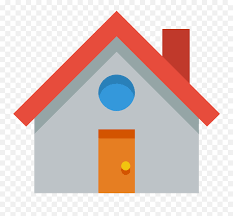
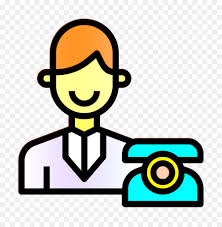
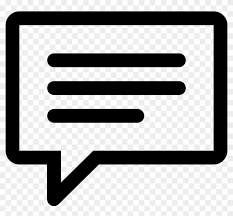
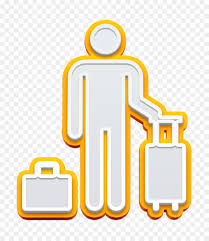

In [108]:
reviews_data_info = np.array([
                              ['Property Number', df_reviews_detailed['listing_id'].nunique()],
                              ['Host Number', df_reviews_detailed['host_id'].nunique()],
                              ['Review Number', len(df_reviews_detailed)],
                              ['Reviewer Number', df_reviews_detailed['reviewer_id'].nunique()],                
])
df_reviews_data_info = pd.DataFrame(reviews_data_info, columns=['name', 'value'])

print('Coverage of Reviews Data:')
display(HTML(df_reviews_data_info.to_html(index=False, header=False)))

df_to_plot = df_reviews_data_info.astype({'value': 'int32'})
fig = go.Figure()
fig.add_trace(go.Bar(
                 x=df_to_plot['name'],
                 y=df_to_plot['value'],
                 )
             )

icon_names = {}
icon_names['Host Number'] = DIR_PREFIX+"images/icon_host.jpg"
icon_names['Property Number'] = DIR_PREFIX+"images/icon_house.png"
icon_names['Review Number'] = DIR_PREFIX+"images/icon_review.png"
icon_names['Reviewer Number'] = DIR_PREFIX+"images/icon_guest.jpg"

for x in fig.data[0].x:
  fig.add_layout_image(
      source=Image.open(icon_names[x]),
      x=x,
      y=-0.1,
      xref='x',
      yref='paper',
      xanchor='center',
      sizex=0.3,
      sizey=0.3
  )
fig.update_layout(
    title='Fig 11. Coverage of Reviews Data',
    width=800,
    height=500,
    )
fig.show(renderer='colab')

### Create network and identify groups. ###

In [48]:
import networkx as nx

def create_graph():
  graph = nx.Graph()
  for user_id, group in df_reviews_detailed.groupby('reviewer_id'):
    listings = group['listing_id'].tolist()
    if len(listings) > 1:
      for i in range(len(listings) - 1):
        for j in range(i + 1, len(listings)):
          n1 = listings[i] 
          n2 = listings[j]
          if graph.has_edge(n1, n2):
            graph[n1][n2]['strength'] += 1
            graph[n1][n2]['distance'] = 1.0 / graph[n1][n2]['strength']
          else:
            graph.add_edge(n1, n2, strength=1)
            graph[n1][n2]['distance'] = 1.0
  return graph

graph = create_graph()
#print('graph size:')
#print('nodes:', len(graph.nodes))
#print('edges:', len(graph.edges))


def prune_graph(graph):
  for n1, n2, d in list(graph.edges(data=True)):
    if d['strength'] < 5:
      graph.remove_edge(n1, n2)

  for component in list(nx.connected_components(graph)):
    if len(component) < 10:
      for node in component:
        graph.remove_node(node)
  return graph

graph = prune_graph(graph)
#print('graph size:')
#print('nodes:', len(graph.nodes))
#print('edges:', len(graph.edges))


from networkx import edge_betweenness_centrality as betweenness

def find_groups(graph):
  def most_central_edge(G):
      centrality = betweenness(G, weight="distance")
      return max(centrality, key=centrality.get)

  communities_generator = nx.algorithms.community.girvan_newman(graph, most_valuable_edge=most_central_edge)

  levels = {}
  for i in range(10):
    levels[i] = next(communities_generator)
  return levels

levels = find_groups(graph)


graph size:
nodes: 9853
edges: 73765


In [20]:
# this code is used to store intermediate result on drive, so as to save time

import json

def set_default(obj):
    if isinstance(obj, set):
        return list(obj)
    raise TypeError
with open(DIR_PREFIX+'data_airbnb_syd/20211106/group_levels.json', 'w') as fp:
  json.dump(levels, fp, default=set_default)


### Create labels (word clouds) for groups. ###

In [10]:
# code for creating word cloud

# groups is {group_id: [item_id, item_id, ....] }
# cols_for_tokens is list of column names
def create_docs_for_groups(groups, df, col_for_item_id, cols_for_tokens, stop_words=[]):
    docs = {}
    for group_id, item_id_list in groups.items():
      docs[group_id] = []
      for col in cols_for_tokens:
        sentence_list = df[df[col_for_item_id].isin(item_id_list)][col]
        for sent in sentence_list:
          sent_cleaned = [tok for tok in sent.split() if tok not in stop_words]
          docs[group_id].extend(sent_cleaned)
    return docs


# docs is {doc_id: [tok, tok, tok, tok, ....]}
def doc_tfidf(docs):
    
    vocab = set()
    for doc_id, doc_tokens in docs.items():
        vocab.update(doc_tokens)
    vocab = sorted(list(vocab))


    docs_tf = {}

    for doc_id, doc_tokens in docs.items():
        word_count = Counter()
        word_count.update(doc_tokens)
        doc_size = sum(word_count.values())
        for w in word_count.keys():
            word_count[w] = (word_count[w] + 1) / doc_size
        docs_tf[doc_id] = dict(word_count)
        for k in docs_tf[doc_id].keys():
            docs_tf[doc_id][k] = docs_tf[doc_id][k] / doc_size
        


    docs_number = len(docs)
    docs_idf = {w: 0 for w in vocab}
        
    for doc_id, word_count in docs_tf.items():
        for word in word_count.keys():
            docs_idf[word] += 1
    for w in docs_idf.keys():
        docs_idf[w] = np.log(docs_number / (1 + docs_idf[w])) + 1

    docs_tfidf = {}
    for doc_id in docs_tf.keys():
        docs_tfidf[doc_id] = {}
        for w in docs_tf[doc_id].keys():
            docs_tfidf[doc_id][w] = docs_tf[doc_id][w] * docs_idf[w]

        
    for n in docs_tf.keys():
        docs_tf[n] = sorted(docs_tf[n].items(), key=lambda item: item[1], reverse=True)
    for n in docs_tfidf.keys():
        docs_tfidf[n] = sorted(docs_tfidf[n].items(), key=lambda item: item[1], reverse=True)
    return docs_tfidf, docs_tf

df_listings_detailed_lemmanized = pd.read_csv(DIR_PREFIX+"data_airbnb_syd/20211106/listings_detailed_lemmatized.csv",
                                              usecols=['id', 'name_lemmas', 'description_lemmas', 'neighborhood_overview_lemmas'])

In [17]:
id2community = {}
child2parent = {}
community_sequence = []
for i in range(len(levels)):
  for c in levels[i]:
    c = set(c)
    if not c in community_sequence:
      community_sequence.append(c)
      for j in range(len(community_sequence)-2, -1, -1):
        if c.issubset(community_sequence[j]):
          child2parent[len(community_sequence)-1] = j
          break


id2community = {idx: c for idx, c in enumerate(community_sequence)}
stop_words = ['sydney','guest', 'walk']
group_docs = create_docs_for_groups(groups=id2community, df=df_listings_detailed_lemmanized, col_for_item_id='id', cols_for_tokens=['description_lemmas', 'neighborhood_overview_lemmas'], stop_words=stop_words)

groups_tfidf, groups_tf = doc_tfidf(group_docs)

import json

def set_default(obj):
    if isinstance(obj, set):
        return list(obj)
    raise TypeError
with open(DIR_PREFIX+'data_airbnb_syd/20211106/group_tfidf.json', 'w') as fp:
  json.dump(groups_tfidf, fp, default=set_default)


group_number = len(groups_tfidf)


In [52]:
import json
with open(DIR_PREFIX+'data_airbnb_syd/20211106/group_levels.json', 'r') as fp:
  levels = json.load(fp)
id2community = {}
child2parent = {}
community_sequence = []
for i in range(len(levels)):
  for c in levels[str(i)]:
    c = set(c)
    if not c in community_sequence:
      community_sequence.append(c)
      for j in range(len(community_sequence)-2, -1, -1):
        if c.issubset(community_sequence[j]):
          child2parent[len(community_sequence)-1] = j
          break


id2community = {idx: c for idx, c in enumerate(community_sequence)}

with open(DIR_PREFIX+'data_airbnb_syd/20211106/group_tfidf.json', 'r') as fp:
  groups_tfidf = json.load(fp)


### Display hierarchy of groups. ###

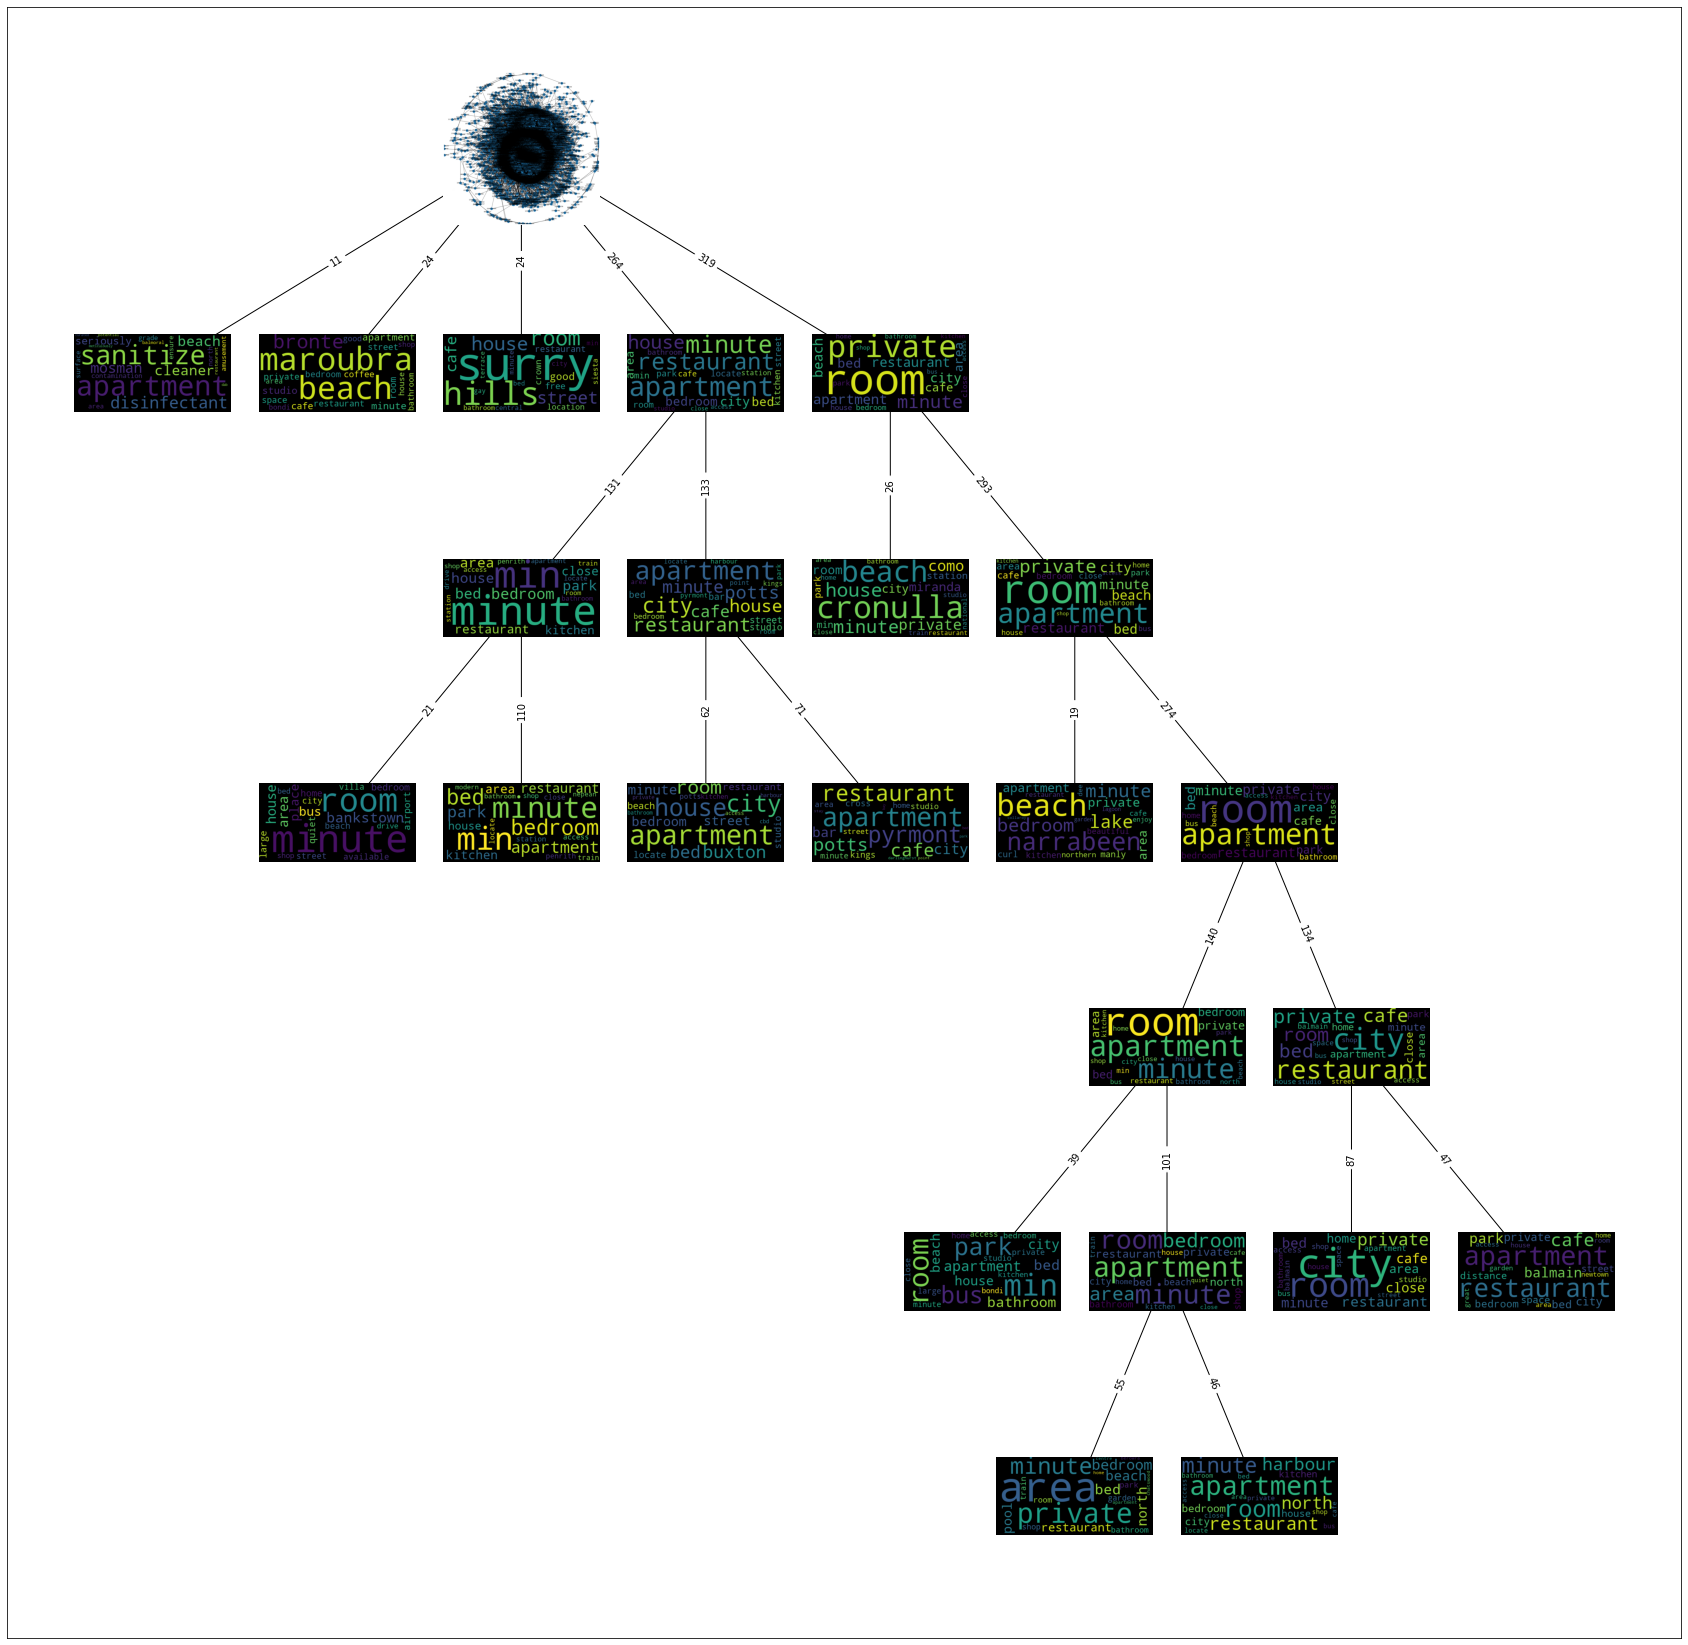

In [54]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

property_cluster_graph = nx.DiGraph()
property_cluster_graph.add_node('all')
image_store = {}
image_store['all'] = mpimg.imread(DIR_PREFIX+"data_airbnb_syd/20211106/layout.png")
for id in id2community.keys():
  wordcloud = WordCloud()
  wordcloud.generate_from_frequencies(dict(groups_tfidf[str(id)][:20]))
  image_store[id] = wordcloud
  property_cluster_graph.add_node(id)

#print(property_cluster_graph.nodes())
edge_labels = {}
for id in id2community.keys():
  property_cluster_graph.add_edge(id, child2parent.get(id, 'all'))
  edge_labels[(id, child2parent.get(id, 'all'))] = len(id2community[id])
#print(property_cluster_graph.edges())

# Get a reproducible layout and create figure
#pos=nx.spring_layout(property_cluster_graph, scale=1)
#pos = nx.kamada_kawai_layout(property_cluster_graph)
#pos = nx.nx_agraph.graphviz_layout(property_cluster_graph, prog="twopi", args="")
pos = graphviz_layout(property_cluster_graph, prog="dot")
#pos = graphviz_layout(property_cluster_graph, prog="circo")
#pos = graphviz_layout(property_cluster_graph, prog="twopi")
xmax = max([x for x, y in pos.values()])
xmin = min([x for x, y in pos.values()])
ymax = max([y for x, y in pos.values()])
ymin = min([y for x, y in pos.values()])
for k in pos.keys():
  x, y = pos[k]
  pos[k] = [1 - x / (xmax-xmin), 1 - y / (ymax-ymin)]
fig, ax = plt.subplots()
fig.set_size_inches(30, 30)
nx.draw_networkx_edges(
    property_cluster_graph,
    pos=pos,
    ax=ax,
    arrows=True,
    arrowstyle="-",
    min_source_margin=15,
    min_target_margin=15,
)

nx.draw_networkx_edge_labels(
    property_cluster_graph,
    pos=pos,
    ax=ax,
    edge_labels=edge_labels
)
# Transform from data coordinates (scaled between xlim and ylim) to display coordinates
tr_figure = ax.transData.transform
# Transform from display to figure coordinates
tr_axes = fig.transFigure.inverted().transform

# Select the size of the image (relative to the X axis)
icon_size = (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.06
icon_center = icon_size / 2.0

# Add the respective image to each node
for n in property_cluster_graph.nodes:
    xf, yf = tr_figure(pos[n])
    xa, ya = tr_axes((xf, yf))
    # get overlapped axes and plot icon
    a = plt.axes([xa - icon_center, ya - icon_center, icon_size, icon_size])
    a.imshow(image_store[n])
    a.axis("off")
#plt.show()
plt.savefig(DIR_PREFIX+'data_airbnb_syd/20211106/cluster.png')

### Conclusion ###
This work utilises data publicly available on insideairbnb.com to carry out analysis on AirBnb hosts and properties in Sydney.
- We find currently active hosts have been in business for 6 years in average, 13 years at most, less than 1 year at least.
- Importantly and interestingly, host business size (measured in number of properites) demonstrates long tail distribution (Power Law Distribution) clearly, which indicates the potential outcome of "big host get bigger". 
  - Long tail distribution of host business size is identified in Sydney and all of other 4 randomly selected cities in the world.
  - Theoretical upperbound of biggest host varies in cities, from slightly above 1% up to nearly 30% of the city's total AirBnb properties. Important questions include "whether the theoretical uppoerbound will be actually reached" and "what consequences of the trend are". Answering these questions is beyond the scope of this work, but might be of great value to stackholders relevant to AirBnb market.   
- Utilising techniques of Social Netowrk Analysis and data of AirBnb guests' reviews, we identify groups of properties based on preferences of guests. The approach and resultant groups can be used for, e.g.
  - recommending properties to guests
  - grouping guests (customer segmentation)
  - positionning a property in market
  - identifying a property's potential customers
